# No-Day User Constraint for Weather Data Generation 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import scipy
from scipy.stats import chisquare

from collections import Counter

## Load Data

In [2]:
data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
data_test = pd.read_csv('data/om-2025-test.csv', delimiter=",", skiprows=3 )

In [ ]:
# mapping for renaming purposes
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}

def rename_columns(df):
    '''
    Function to rename columns in accordance to mapping
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
    '''
    df.rename(columns=weather_columns, inplace=True)
    return df

def add_time_columns(df):
    '''
    Function to convert time column to datetime and add more time related columns, such as month, day, year ... 

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.

    '''
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Handle parsing errors
    df = df.dropna(subset=['time'])  # Drop rows with invalid dates
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),
        format='%m-%d-%Y %H:%M:%S'
    )
    return df

In [4]:
data_test['time'] = pd.to_datetime(data_test['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
data_raw['time'] = pd.to_datetime(data_raw['time'], format='%Y-%m-%dT%H:%M', errors='coerce')
all_data = rename_columns(data_raw)
all_data = add_time_columns(all_data)
test_data = rename_columns(data_test)
test_data = add_time_columns(test_data)

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_84796/1286158716.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['time'].dt.month
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_84796/1286158716.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['time'].dt.day
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_84796/1286158716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [5]:
test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')

/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_84796/223361395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['temp'] = pd.to_numeric(test_data['temp'], errors='coerce')
/var/folders/8s/z9nb_fz50j39t__ftkhgz5pc0000gn/T/ipykernel_84796/223361395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sunshine'] = pd.to_numeric(test_data['sunshine'], errors='coerce')


## Categorize Weather Variables

In [6]:
## Average the data
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()
daily_mean_test_df = test_data.select_dtypes(include=[np.number]).groupby(['year', 'month', 'day']).mean().reset_index()

In [7]:
# Calculate Monthly Percentiles

def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

In [8]:
df_states1 = calculate_percentiles_and_categorize(daily_mean_df, 1)
df_states1_test = calculate_percentiles_and_categorize(daily_mean_test_df, 1)

In [9]:
# combine categories to make a weather state with temperature and precipitation
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)
df_states1_test['state1_test'] = df_states1_test[['temp_category', 'precip_category']].agg('-'.join, axis=1)

## Transition Matrix 

In [10]:
df = df_states1[['state1']].copy()
df_test = df_states1_test[['state1_test']].copy()
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.439560  0.065934     0.197802  0.000000  0.000000   
High-Low        0.333333  0.250000     0.291667  0.000000  0.000000   
High-Medium     0.380952  0.095238     0.190476  0.000000  0.000000   
Low-High        0.000000  0.035714     0.000000  0.178571  0.250000   
Low-Low         0.033333  0.011111     0.011111  0.111111  0.577778   
Low-Medium      0.027778  0.055556     0.027778  0.138889  0.472222   
Medium-High     0.142857  0.000000     0.040816  0.102041  0.061224   
Medium-Low      0.181818  0.045455     0.068182  0.000000  0.159091   
Medium-Medium   0.133333  0.050000     0.033333  0.050000  0.050000   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.021978     0.087912    0.043956       0.142857  
High-Low      

## Add values for each category 

In [11]:
def values_list(df, weather_var, category, weather_cat): 
    '''Creates a list of values for each weather variable for each category'''
    cat_rows = df.loc[df[weather_cat] == category]
    val_list = cat_rows[weather_var].to_list() 
    v_list = [ '%.1f' % elem for elem in val_list ]
    return v_list

In [12]:
# get low, med, high temperatures of january for further implementation
temp_low1 = values_list(df_states1, 'temp', 'Low', 'temp_category')
temp_med1 = values_list(df_states1, 'temp', 'Medium', 'temp_category')
temp_high1 = values_list(df_states1, 'temp', 'High', 'temp_category')

# get low, med, high precipitation of january for further implementation
prec_low1 = values_list(df_states1, 'precip', 'Low', 'precip_category')
prec_med1 = values_list(df_states1, 'precip', 'Medium', 'precip_category')
prec_high1 = values_list(df_states1, 'precip', 'High', 'precip_category')

all_temp = temp_low1 + temp_med1 + temp_high1

In [13]:
from scipy.stats import norm, gamma

temp_low1 = [float(x) for x in temp_low1]
temp_med1 = [float(x) for x in temp_med1]
temp_high1 = [float(x) for x in temp_high1]

prec_low1 = [float(x) for x in prec_low1]
prec_med1 = [float(x) for x in prec_med1]
prec_high1 = [float(x) for x in prec_high1]
# Example: fit temperature distributions
temp_low_params = norm.fit(temp_low1)  # returns mean and std
temp_med_params = norm.fit(temp_med1)
temp_high_params = norm.fit(temp_high1)

## Change Transition Matrix to No-Days constraint

In [14]:
def implement_no_days_constraint(transition_matrix, states, excluded_state):
    """
    Modify transition matrix to avoid a specific state
    
    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        excluded_state: The state that must not appear
        
    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()
    
    # Get index of excluded state
    excluded_idx = states.index(excluded_state)
    
    # Set all transitions to excluded state to zero
    for state in states:
        if state != excluded_state:  # Handle other states
            # Get current probability of transitioning to excluded state
            current_prob = modified_matrix.loc[state, excluded_state]
            
            if current_prob > 0:
                # Set transition to excluded state to zero
                modified_matrix.loc[state, excluded_state] = 0
                
                # Redistribute probability to other states
                other_states = [s for s in states if s != excluded_state]
                other_probs_sum = modified_matrix.loc[state, other_states].sum()
                
                if other_probs_sum > 0:  # Avoid division by zero
                    for other_state in other_states:
                        modified_matrix.loc[state, other_state] *= (1 + current_prob/other_probs_sum)
        
        else:  # Handle the excluded state itself
            # Handle case where initial state is the excluded state
            # Redistribute all probability to other states uniformly
            modified_matrix.loc[excluded_state] = 0
            for other_state in [s for s in states if s != excluded_state]:
                modified_matrix.loc[excluded_state, other_state] = 1.0 / (len(states) - 1)
    
    # Ensure rows still sum to 1
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum
    
    return modified_matrix


## Markov Chain Implementation

In [15]:
def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state for the simulation
        steps: Number of steps to simulate
        
    Returns:
        List of states in the simulated sequence
    '''

    # initialise current state
    current_state = initial_state
    
    # add current state to the list of sequences 
    state_sequence = [current_state]
    
    # generate n steps of states
    for _ in range(steps):
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state
    
    return state_sequence

In [16]:

def monte_carlo_markov_chain(transition_matrix, states, initial_state=None, steps=31, n_simulations=1000):
    '''
    Performs Monte Carlo simulation of a Markov Chain
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        initial_state: Starting state (if None, will be randomly chosen based on stationary distribution)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'ci_lower', 'ci_upper': 95% confidence intervals for state frequencies
        - 'all_sequences': List of all simulated sequences (optional, can be removed if memory is a concern)
    '''


    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}

    # If no initial state is provided, use stationary distribution to choose one
    if initial_state is None:
        # Approximate stationary distribution by raising transition matrix to high power
        # This requires transition_matrix to be a numpy array, so convert if needed
        if isinstance(transition_matrix, pd.DataFrame):
            tm_numpy = transition_matrix.values
        else:
            tm_numpy = transition_matrix
            
        # Initialize a uniform distribution
        p = np.ones(len(states)) / len(states)
        
        # Multiply by transition matrix multiple times to approximate stationary distribution
        for _ in range(100):  # Usually 100 iterations is enough for convergence
            p = p @ tm_numpy
            
        # Choose initial state based on stationary distribution
        initial_state = np.random.choice(states, p=p)
    
    # Run n_simulations
    for _ in range(n_simulations):
        # For each simulation, potentially use a different initial state from stationary distribution
        if initial_state is None:
            sim_initial_state = np.random.choice(states, p=p)
        else:
            sim_initial_state = initial_state
            
        # Run one simulation
        sequence = simulate_markov_chain(transition_matrix, states, sim_initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    # Calculate 95% confidence intervals
    ci_lower = {state: np.percentile(counts, 2.5) for state, counts in all_counts.items()}
    ci_upper = {state: np.percentile(counts, 97.5) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'all_sequences': all_sequences 
    }



In [17]:

def analyze_monte_carlo_results(mc_results, real_data, states, test_sequence=None):
    '''
    Analyzes and visualizes the results of Monte Carlo simulation
    
    Args:
        mc_results: Results from monte_carlo_markov_chain function
        real_data: Dictionary or Counter with actual observed frequencies
        states: List of possible states
        test_sequence: Optional test sequence to compare with simulated sequences
        
    Returns:
        Dictionary with analysis metrics
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import chisquare
    
    # Extract results
    mean_counts = mc_results['mean_counts']
    std_counts = mc_results['std_counts']
    ci_lower = mc_results['ci_lower']
    ci_upper = mc_results['ci_upper']
    
    # Prepare data for visualization
    simulated_means = [mean_counts[state] for state in states]
    error_bars = [std_counts[state] for state in states]
    real_counts = [real_data.get(state, 0) for state in states]
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    plt.bar(x - width/2, simulated_means, width, label='Simulated (Monte Carlo)', yerr=error_bars, alpha=0.7)
    plt.bar(x + width/2, real_counts, width, label='Real Data', alpha=0.7)
    
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation vs. Real Weather States')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig('monte_carlo_analysis.png')
    
    # Calculate Chi-square statistic
    chi2_stat, p_value = chisquare(f_obs=real_counts, f_exp=simulated_means)
    
    # Calculate mean absolute error
    mae = np.mean([abs(real_counts[i] - simulated_means[i]) for i in range(len(states))])
    mse = np.mean([(real_counts[i] - simulated_means[i])**2 for i in range(len(states))])
    mape = np.mean([abs(real_counts[i] - simulated_means[i]) / real_counts[i] for i in range(len(states)) if real_counts[i] != 0])
    
    # Check if real values fall within confidence intervals
    within_ci = [ci_lower[state] <= real_data.get(state, 0) <= ci_upper[state] for state in states]
    percent_within_ci = sum(within_ci) / len(states) * 100

    # Prepare results
    results = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'statistically_similar': p_value > 0.05,
        'mean_absolute_error': mae,
        'mean_squared_error': mse,
        'mean_absolute_percentage_error': mape,
        'percent_within_ci': percent_within_ci,
        'states_outside_ci': [states[i] for i in range(len(states)) if not within_ci[i]]
    }
    
    # Print summary
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Distributions are statistically similar: {p_value > 0.05}")
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Mean squared error: {mse:.2f}")
    print(f"Mean absolute percentage error: {mape:.2f}")
    print(f"Percentage of states within 95% CI: {percent_within_ci:.1f}%")
    print(f"States outside confidence intervals: {results['states_outside_ci']}")
    
    return results

In [18]:
# Count the frequency of each state
from collections import Counter

# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Simulate the Markov Chain
steps = 30
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)
state_counts = Counter(state_sequence)

state_sequence_test = []
for i in df_test['state1_test']:
    state_sequence_test.append(i)

state_counts_test = Counter(state_sequence_test)

Chi-square statistic: 4.5781
p-value: 0.8016
Distributions are statistically similar: True
Mean absolute error: 0.82
Mean squared error: 1.76
Mean absolute percentage error: 0.15
Percentage of states within 95% CI: 88.9%
States outside confidence intervals: ['High-Low']


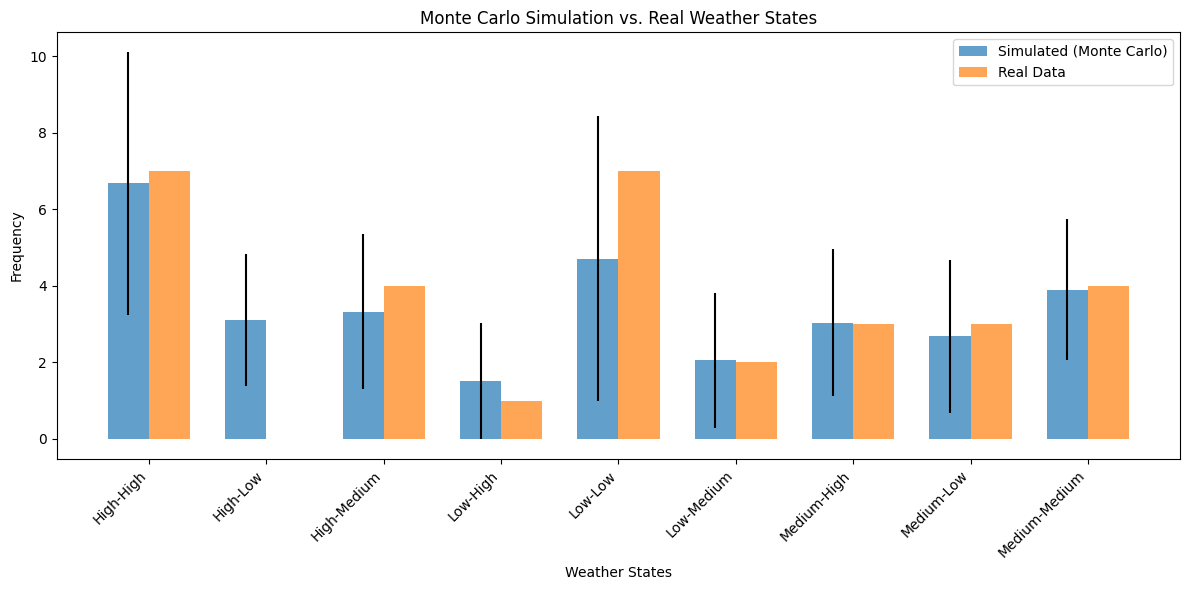

In [19]:

# Run Monte Carlo simulation
mc_results = monte_carlo_markov_chain(
    transition_matrix=transition_matrix,
    states=all_states, 
    steps=30,  # for January
    n_simulations=1000, 
)

# Analyze results
analysis = analyze_monte_carlo_results(
    mc_results=mc_results,
    real_data=state_counts_test, 
    states=all_states,
    test_sequence= state_sequence_test
)

## Constrained Markov Chain - No Day Constraint 

In [20]:
def implement_no_days_constraint(transition_matrix, states, excluded_state):
    """
    Modify transition matrix to avoid a specific state
    
    Args:
        transition_matrix: Original transition matrix (Pandas DataFrame)
        states: List of possible states
        excluded_state: The state that must not appear
        
    Returns:
        Modified transition matrix
    """
    # Create a copy of the transition matrix
    modified_matrix = transition_matrix.copy()
    
    # Get index of excluded state
    excluded_idx = states.index(excluded_state)
    
    # Set all transitions to excluded state to zero
    for state in states:
        if state != excluded_state:  # Handle other states
            # Get current probability of transitioning to excluded state
            current_prob = modified_matrix.loc[state, excluded_state]
            
            if current_prob > 0:
                # Set transition to excluded state to zero
                modified_matrix.loc[state, excluded_state] = 0
                
                # Redistribute probability to other states
                other_states = [s for s in states if s != excluded_state]
                other_probs_sum = modified_matrix.loc[state, other_states].sum()
                
                if other_probs_sum > 0:  # Avoid division by zero
                    for other_state in other_states:
                        modified_matrix.loc[state, other_state] *= (1 + current_prob/other_probs_sum)
        
        else:  # Handle the excluded state itself
            # Handle case where initial state is the excluded state
            # Redistribute all probability to other states uniformly
            modified_matrix.loc[excluded_state] = 0
            for other_state in [s for s in states if s != excluded_state]:
                modified_matrix.loc[excluded_state, other_state] = 1.0 / (len(states) - 1)
    
    # Ensure rows still sum to 1
    for state in states:
        row_sum = modified_matrix.loc[state].sum()
        if abs(row_sum - 1.0) > 1e-10:  # If not very close to 1
            modified_matrix.loc[state] /= row_sum
    
    return modified_matrix

In [21]:

def generate_no_days_constraint_sequence(transition_matrix, states, excluded_state, 
                                        initial_state=None, steps=31):
    """
    Generate a sequence with no occurrences of excluded_state
    
    Args:
        transition_matrix: Your transition probability matrix (Pandas DataFrame)
        states: List of possible states
        excluded_state: State that must not appear
        initial_state: Starting state (if None, will be randomly selected)
        steps: Number of days to generate
        
    Returns:
        A sequence that contains no occurrences of excluded_state
    """
    # Modify transition matrix to avoid excluded state
    modified_matrix = implement_no_days_constraint(transition_matrix, states, excluded_state)
    
    # If no initial state is provided or if initial state is the excluded state, choose another one
    if initial_state is None or initial_state == excluded_state:
        available_states = [s for s in states if s != excluded_state]
        initial_state = np.random.choice(available_states)
        
    # Ensure initial_state is not None before passing to simulate_markov_chain
    if initial_state is None:
        raise ValueError("Initial state cannot be None")
        
    # Generate sequence with modified matrix
    sequence = simulate_markov_chain(modified_matrix, states, initial_state, steps)
    
    return sequence

In [22]:
def monte_carlo_with_no_days_constraint(transition_matrix, states, excluded_state, 
                                       initial_state=None, steps=31, n_simulations=1000):
    """
    Performs Monte Carlo simulation with no days constraint
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states
        excluded_state: State that must not appear
        initial_state: Starting state (if None, will be randomly chosen)
        steps: Number of steps to simulate in each run
        n_simulations: Number of simulations to run
        
    Returns:
        Dictionary containing:
        - 'mean_counts': Average count of each state across all simulations
        - 'std_counts': Standard deviation of counts for each state
        - 'all_sequences': List of all simulated sequences
    """
    # Initialize storage for all simulations
    all_sequences = []
    all_counts = {state: [] for state in states}
    
    # Run n_simulations
    for _ in range(n_simulations):
        # Run one constrained simulation
        sequence = generate_no_days_constraint_sequence(
            transition_matrix, states, excluded_state, initial_state, steps)
        all_sequences.append(sequence)
        
        # Count occurrences of each state in this simulation
        counts = Counter(sequence)
        for state in states:
            all_counts[state].append(counts.get(state, 0))
    
    # Calculate statistics
    mean_counts = {state: np.mean(counts) for state, counts in all_counts.items()}
    std_counts = {state: np.std(counts) for state, counts in all_counts.items()}
    
    return {
        'mean_counts': mean_counts,
        'std_counts': std_counts,
        'all_sequences': all_sequences
    }

In [23]:
def analyze_no_days_constraint_effect(transition_matrix, states, excluded_state, 
                                     real_data=None, test_sequence=None, n_simulations=1000, steps=31):
    """
    Analyze the effect of the no days constraint by comparing with unconstrained model
    
    Args:
        transition_matrix: Pandas DataFrame with states as indices and columns
        states: List of possible states  
        excluded_state: State that must not appear
        real_data: Optional dictionary or Counter with actual observed frequencies
        test_sequence: Optional test sequence to compare with simulated sequences
        n_simulations: Number of simulations to run
        steps: Number of steps to simulate in each run
        
    Returns:
        Dictionary with analysis metrics
    """
    # Import necessary libraries if not already imported
    from scipy.stats import chisquare
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Run Monte Carlo simulations
    print(f"Running Monte Carlo simulation with no days constraint for excluded state '{excluded_state}'...")
    constrained_results = monte_carlo_with_no_days_constraint(
        transition_matrix, states, excluded_state, steps=steps, n_simulations=n_simulations)
    
    print(f"Running Monte Carlo simulation without constraints for comparison...")
    unconstrained_results = monte_carlo_markov_chain(
        transition_matrix, states, steps=steps, n_simulations=n_simulations)
    
    # Extract statistical results
    constrained_means = constrained_results['mean_counts']
    constrained_stds = constrained_results['std_counts']
    unconstrained_means = unconstrained_results['mean_counts']
    unconstrained_stds = unconstrained_results['std_counts']
    
    # Calculate constraint satisfaction rate
    # Count sequences with at least one occurrence of excluded state
    constrained_sequences = constrained_results['all_sequences']
    unconstrained_sequences = unconstrained_results['all_sequences']
    const_with_excluded = sum(1 for seq in constrained_sequences if excluded_state in seq)
    unconst_with_excluded = sum(1 for seq in unconstrained_sequences if excluded_state in seq)
    const_satisfaction_rate = (1 - const_with_excluded / n_simulations) * 100  
    unconst_satisfaction_rate = (1 - unconst_with_excluded / n_simulations) * 100
    
    # Prepare data for visualization (state comparison)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(states))
    width = 0.35
    
    # Set means for visualization
    vis_const_means = [constrained_means.get(state, 0) for state in states]
    vis_unconst_means = [unconstrained_means.get(state, 0) for state in states]
    
    # Set standard deviations for error bars
    vis_const_stds = [constrained_stds.get(state, 0) for state in states]
    vis_unconst_stds = [unconstrained_stds.get(state, 0) for state in states]
    
    # Create bar plot
    plt.bar(x - width/2, vis_unconst_means, width, yerr=vis_unconst_stds, 
            label='Unconstrained', alpha=0.7)
    plt.bar(x + width/2, vis_const_means, width, yerr=vis_const_stds, 
            label=f'No Days Constraint ({excluded_state} excluded)', alpha=0.7)
    
    # Add real data if provided
    if real_data is not None:
        real_counts = [real_data.get(state, 0) for state in states]
        plt.plot(x, real_counts, 'ro', label='Real Data', markersize=8)
        
    # Format plot - Frequency plot 
    plt.xlabel('Weather States')
    plt.ylabel('Frequency')
    plt.title(f'Effect of No Days Constraint (Excluded: {excluded_state})')
    plt.xticks(x, states, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('no_days_constraint_analysis.png')
    
    # Calculate impact on excluded state frequency
    excluded_constrained = constrained_means.get(excluded_state, 0)  # Should be 0
    excluded_unconstrained = unconstrained_means.get(excluded_state, 0)
    excluded_diff = excluded_constrained - excluded_unconstrained
    
    # Calculate statistics
    # Prepare vectors for chi-square test
    const_vector = [constrained_means.get(state, 0) for state in states]
    unconst_vector = [unconstrained_means.get(state, 0) for state in states]
    
    # Run chi-square test
    chi2_stat, p_value = chisquare(const_vector, f_exp=unconst_vector)
    
    # Calculate mean absolute error between constrained and unconstrained
    mae = np.mean([abs(constrained_means.get(state, 0) - unconstrained_means.get(state, 0)) 
                  for state in states])
    
    # Calculate state impacts
    state_impacts = {}
    for state in states:
        diff = constrained_means.get(state, 0) - unconstrained_means.get(state, 0)
        state_impacts[state] = diff
    
    # Find states with largest changes
    sorted_impacts = sorted(state_impacts.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Analyze transition patterns
    # Identify states with significant transitions to excluded state in original model
    significant_from_states = []
    for state in states:
        if state != excluded_state:
            prob_to_excluded = transition_matrix.loc[state, excluded_state]
            if prob_to_excluded > 0.1:  # Threshold for "significant"
                significant_from_states.append((state, prob_to_excluded))
    
    
    # Print summary statistics
    print("\n=== No Days Constraint Analysis Results ===")
    print(f"Excluded state: {excluded_state}")
    print(f"Constraint satisfaction:")
    print(f"  Constrained model: {const_satisfaction_rate:.1f}% of sequences exclude the target state")
    print(f"  Unconstrained model: {unconst_satisfaction_rate:.1f}% of sequences exclude the target state")
    
    print(f"\nExcluded state frequency:")
    print(f"  Unconstrained: {excluded_unconstrained:.2f} days")
    print(f"  Constrained: {excluded_constrained:.2f} days")
    print(f"  Difference: {excluded_diff:.2f} days")
    
    print(f"\nChi-square test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Distributions are {'not ' if p_value < 0.05 else ''}statistically similar")
    
    print(f"\nDifference metrics:")
    print(f"  Mean absolute error: {mae:.4f}")
    
    print(f"\nStates with largest changes in frequency:")
    for state, change in sorted_impacts[:3]:
        print(f"  {state}: {change:+.4f}")
    
    print(f"\nStates with significant transitions to {excluded_state} in the original model:")
    if significant_from_states:
        for state, prob in sorted(significant_from_states, key=lambda x: x[1], reverse=True):
            print(f"  {state} → {excluded_state}: {prob:.3f}")
    else:
        print(f"  No states had significant transitions to {excluded_state}")
    
    # Return comprehensive results
    results = {
        'constrained_results': constrained_results,
        'unconstrained_results': unconstrained_results,
        'excluded_state': excluded_state,
        'const_satisfaction_rate': const_satisfaction_rate,
        'unconst_satisfaction_rate': unconst_satisfaction_rate,
        'state_impacts': state_impacts,
        'sorted_impacts': sorted_impacts,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'mae': mae,
        'significant_transitions': significant_from_states
    }
    
    return results

In [24]:
# Example function to test the implementation
def test_no_days_constraint_monte_carlo():
    """
    Test the no days constraint with Monte Carlo simulation
    """
    # Select a state to exclude
    excluded_state = 'High-High'  # Choose a state that appears frequently
    
    # Run the analysis
    analysis_results = analyze_no_days_constraint_effect(
        transition_matrix=transition_matrix,
        states=all_states,
        excluded_state=excluded_state,
        real_data=state_counts_test,  # Optional: your real January 2025 data
        test_sequence=state_sequence_test,  # Add your test sequence here
        n_simulations=1000,
        steps=31
    )
    
    print("\nMonte Carlo analysis of no days constraint completed!")
    return analysis_results

Running Monte Carlo simulation with no days constraint for excluded state 'High-High'...
Running Monte Carlo simulation without constraints for comparison...

=== No Days Constraint Analysis Results ===
Excluded state: High-High
Constraint satisfaction:
  Constrained model: 100.0% of sequences exclude the target state
  Unconstrained model: 3.2% of sequences exclude the target state

Excluded state frequency:
  Unconstrained: 5.93 days
  Constrained: 0.00 days
  Difference: -5.93 days

Chi-square test:
  Chi-square statistic: 8.3485
  p-value: 0.4002
  Distributions are statistically similar

Difference metrics:
  Mean absolute error: 1.3953

States with largest changes in frequency:
  High-High: -5.9290
  Low-Low: +2.6620
  Medium-Low: +0.9480

States with significant transitions to High-High in the original model:
  High-Medium → High-High: 0.381
  High-Low → High-High: 0.333
  Medium-Low → High-High: 0.182
  Medium-High → High-High: 0.143
  Medium-Medium → High-High: 0.133

Monte Ca

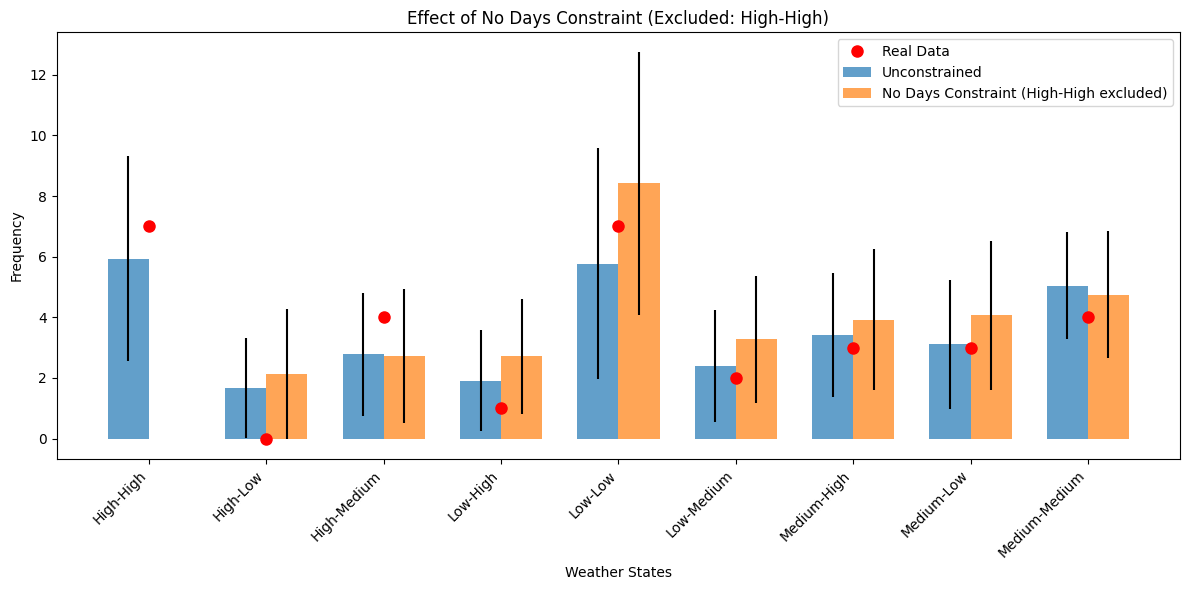

In [25]:
no_day_sim = test_no_days_constraint_monte_carlo()

In [26]:
# get 5 random sequences from monte carlo simulation 
constrained_sequences = no_day_sim['constrained_results']['all_sequences']
random_sequences = random.sample(constrained_sequences, 5)

In [27]:
def seq_heatmap(random_sequences, state_sequence_test ): 
    # Define all possible state labels (make sure it's the full set from your data)
    all_labels = sorted(set([
        "High-High", "High-Medium", "High-Low",
        "Medium-High", "Medium-Medium", "Medium-Low",
        "Low-High", "Low-Medium", "Low-Low"
    ]))

    # Convert all to np.str_ to match your data if needed
    all_labels = list(map(np.str_, all_labels))

    # Convert test sequence counts to a row
    test_counts = Counter(state_sequence_test)
    test_row = [test_counts.get(label, 0) for label in all_labels]

    # Collect counts from generated sequences
    rows = []
    labels = []

    for i, seq in enumerate(random_sequences):
        seq_counts = Counter(seq)
        row = [seq_counts.get(label, 0) for label in all_labels]
        rows.append(row)
        labels.append(f"Generated {i+1}")

    # Add test row
    rows.append(test_row)
    labels.append("Test")

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=all_labels, index=labels)

    # Plot heatmap
    plt.figure(figsize=(14, 7))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={"label": "Frequency"})
    plt.title("Frequency of Weather States in No Day Constrained Generated vs Test Sequences", size =18 )
    plt.ylabel("Sequence", size = 14)
    plt.xlabel("State Label", size =14)
    plt.tight_layout()
    plt.show()
    

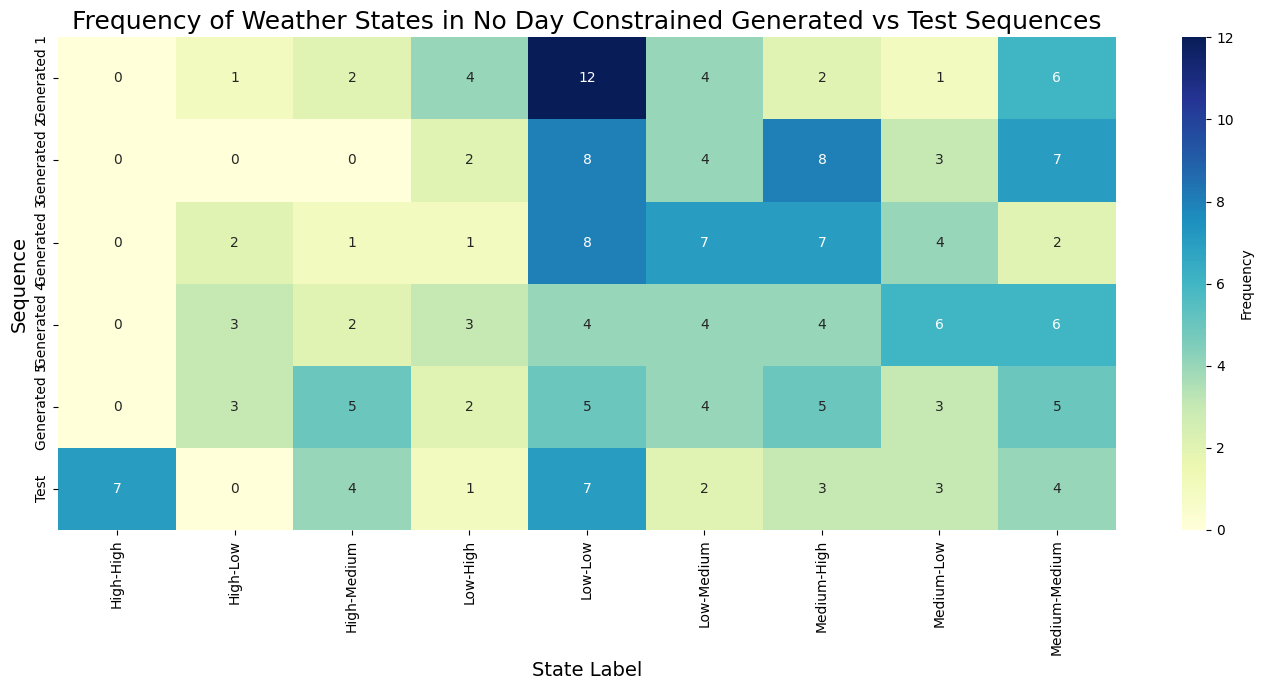

In [28]:
seq_heatmap(random_sequences, state_sequence_test)

In [29]:
def sequence_line_plot(random_sequences, weather_var):
    plt.figure(figsize=(14, 7))

    # Plot the actual (test) sequence
    days = daily_mean_test_df['day']
    plt.plot(days, daily_mean_test_df[weather_var], marker='o', label=f'Test {weather_var.capitalize()}', color='blue', linewidth=2)

    # For each generated sequence
    for idx, gen in enumerate(random_sequences):
        temperature_gen1, precipitation_gen1 = zip(*[str(state).split('-') for state in gen])
        prec_val_gen1 = []
        temp_val_gen1 = []

        for i in temperature_gen1: 
            if i == 'Low': 
                temp_val_gen1.append(float(random.choice(temp_low1)))
            elif i == 'Medium': 
                temp_val_gen1.append(float(random.choice(temp_med1)))
            elif i == 'High': 
                temp_val_gen1.append(float(random.choice(temp_high1)))

        for i in precipitation_gen1: 
            if i == 'Low': 
                prec_val_gen1.append(float(random.choice(prec_low1)))
            elif i == 'Medium': 
                prec_val_gen1.append(float(random.choice(prec_med1)))
            elif i == 'High': 
                prec_val_gen1.append(float(random.choice(prec_high1)))

        df_gen = pd.DataFrame({
            'temp': temp_val_gen1,
            'precip': prec_val_gen1
        })
        df_gen.index = df_gen.index + 1  # match day index

        # Plot the selected variable (temperature or precipitation)
        plt.plot(df_gen.index, df_gen[weather_var], marker='o', label=f'Generated #{idx+1}', alpha=0.6)

    # Dynamic label and title based on variable
    y_label = 'Temperature (°C)' if weather_var == 'temp' else 'Precipitation (mm)'
    title_var = 'Temperature' if weather_var == 'temp' else 'Precipitation'

    plt.xlabel('Day of January', size=18)
    plt.ylabel(y_label, size=18)
    plt.title(f'Average Daily {title_var}: Test vs Generated Sequences (No-Days Constraint)', size=23)
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

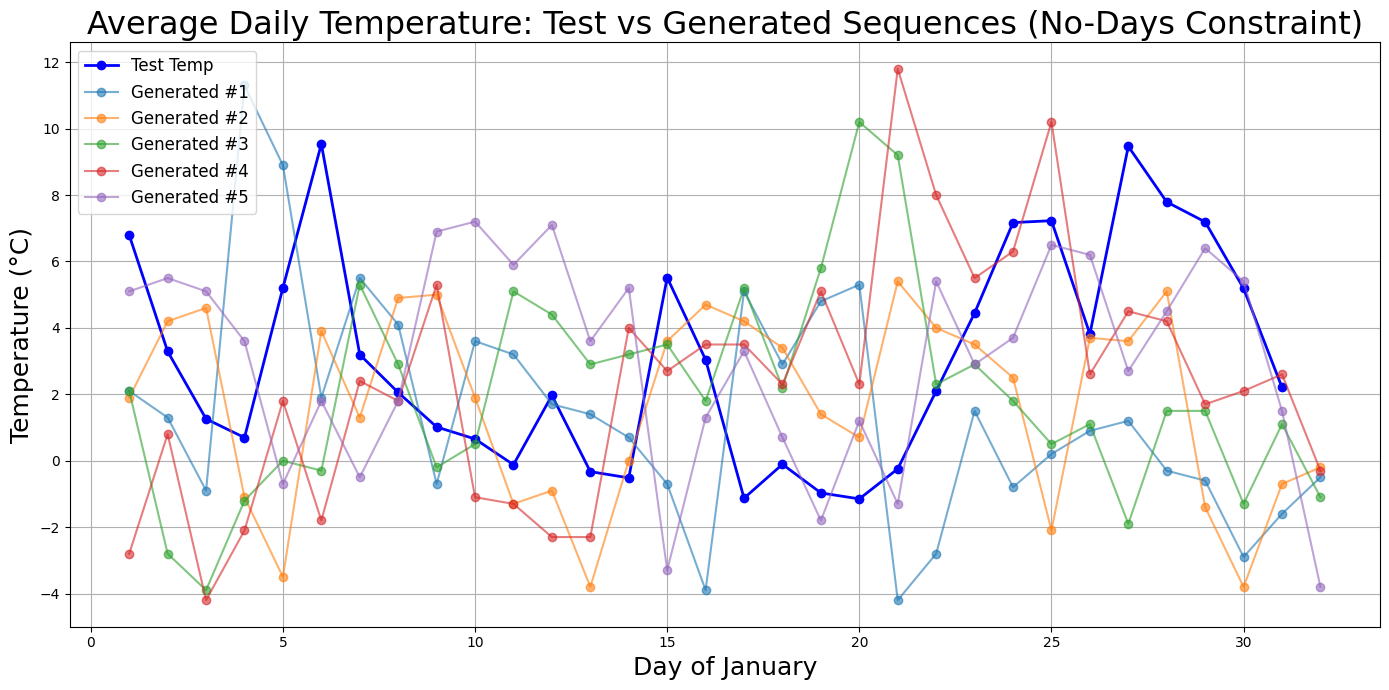

In [30]:
sequence_line_plot(random_sequences, 'temp')

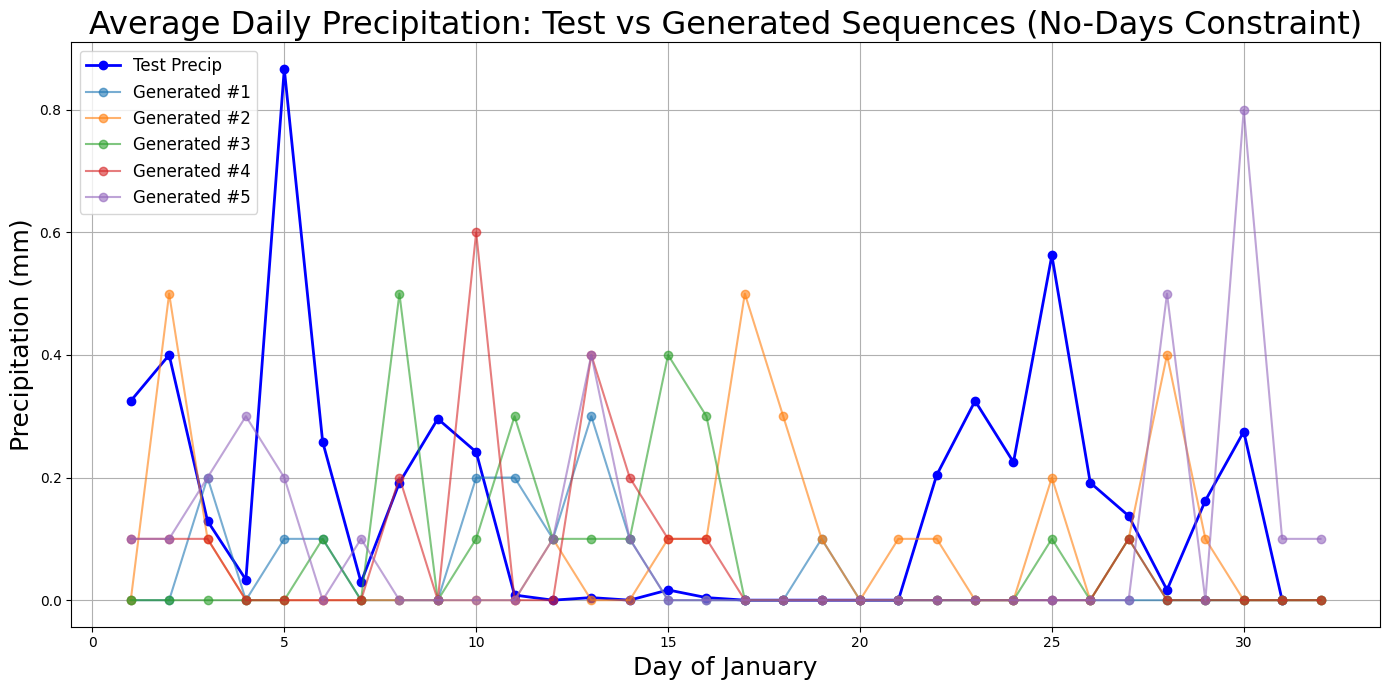

In [31]:
sequence_line_plot(random_sequences, 'precip')

In [48]:
def sequence_line_plot_categorical(random_sequences, state_type='temp'):
    """
    Plot weather sequences showing categorical states (Low, Medium, High) with colored zones
    
    Parameters:
    - random_sequences: list of weather state sequences
    - weather_var: 'temp' or 'precip' 
    - state_type: 'temp' for temperature categories, 'precip' for precipitation categories
    """
    plt.figure(figsize=(14, 7))
    
    # Define categorical mapping
    category_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    category_labels = ['Low', 'Medium', 'High']
    
    # Extract test sequence categories
    test_categories = []
    if state_type == 'temp':
        for _, row in daily_mean_test_df.iterrows():
            if row['temp'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['temp'], 33):
                test_categories.append('Low')
            elif row['temp'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['temp'], 67):
                test_categories.append('Medium')
            else:
                test_categories.append('High')
    else:  # precipitation
        for _, row in daily_mean_test_df.iterrows():
            if row['precip'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['precip'], 33):
                test_categories.append('Low')
            elif row['precip'] <= np.percentile(daily_mean_df[daily_mean_df['month'] == 1]['precip'], 67):
                test_categories.append('Medium')
            else:
                test_categories.append('High')
    
    # Convert test categories to numeric for plotting
    test_numeric = [category_mapping[cat] for cat in test_categories]
    
    # Add colored background zones
    plt.axhspan(-0.25, 0.5, alpha=0.2, color='lightgreen', label='Low')
    plt.axhspan(0.5, 1.5, alpha=0.2, color='yellow', label='Medium')
    plt.axhspan(1.5, 2.25, alpha=0.2, color='lightcoral', label='High')
    
    # Plot the test sequence
    days = daily_mean_test_df['day']
    plt.plot(days, test_numeric, marker='o', label='Test', color='blue', linewidth=2, markersize=4, alpha=0.7)
    
    markers = ['s', 'd', '<', 'X', 'P']
    linestyles = ['--' ]


    # Process and plot generated sequences
    for idx, gen in enumerate(random_sequences):
        if state_type == 'temp':
            categories = [state.split('-')[0] for state in gen]  # Extract temperature part
        else:
            categories = [state.split('-')[1] for state in gen]  # Extract precipitation part
        
        # Convert to numeric for plotting
        numeric_values = [category_mapping[cat] for cat in categories]
        
        # Create day indices (1-31 for January)
        day_indices = list(range(1, len(numeric_values) + 1))
        
        # Use different marker for each sequence
        marker = markers[idx % len(markers)]  # Cycle through markers if more sequences than markers
        linestyle = linestyles[idx % len(linestyles)]

        plt.plot(day_indices, numeric_values, marker=marker, linestyle = linestyle,
                label=f'Generated #{idx+1}', alpha=0.5, linewidth=2.5, markersize=8)
    
    
    # Customize the plot
    # plt.yticks([0, 1, 2], ['Low', 'Medium', 'High'])
    plt.ylim(-0.3, 2.3)
    
    # Add threshold lines
    plt.axhline(y=0.5, color='darkgreen', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axhline(y=1.5, color='darkred', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Labels and title
    var_name = 'Temperature' if state_type == 'temp' else 'Precipitation'
    plt.xlabel('Day of January', size=18)
    plt.ylabel(f'{var_name} Category', size=18)
    plt.title(f'Daily {var_name} Categories: No-Day Constraint (Test vs Generated Sequences)', size=24)
    plt.grid(True, alpha=0.3)
    
    # Legend
    # plt.legend(loc='upper left', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{var_name} Category Distribution:")
    test_counts = {cat: test_categories.count(cat) for cat in category_labels}
    print("Test sequence:", test_counts)
    
    for idx, gen in enumerate(random_sequences):
        if state_type == 'temp':
            gen_categories = [state.split('-')[0] for state in gen]
        else:
            gen_categories = [state.split('-')[1] for state in gen]
        gen_counts = {cat: gen_categories.count(cat) for cat in category_labels}
        print(f"Generated #{idx+1}:", gen_counts)

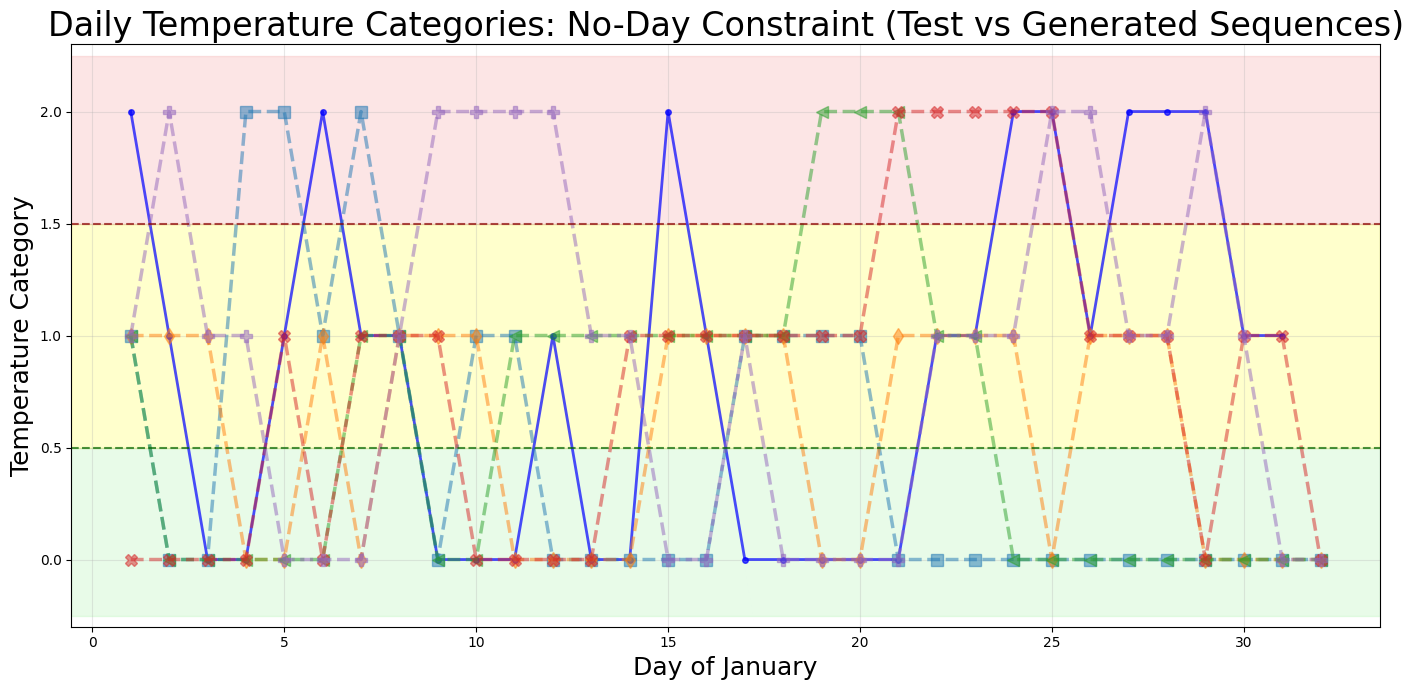


Temperature Category Distribution:
Test sequence: {'Low': 12, 'Medium': 11, 'High': 8}
Generated #1: {'Low': 20, 'Medium': 9, 'High': 3}
Generated #2: {'Low': 14, 'Medium': 18, 'High': 0}
Generated #3: {'Low': 16, 'Medium': 13, 'High': 3}
Generated #4: {'Low': 11, 'Medium': 16, 'High': 5}
Generated #5: {'Low': 11, 'Medium': 13, 'High': 8}


In [49]:
sequence_line_plot_categorical(random_sequences, 'temp')

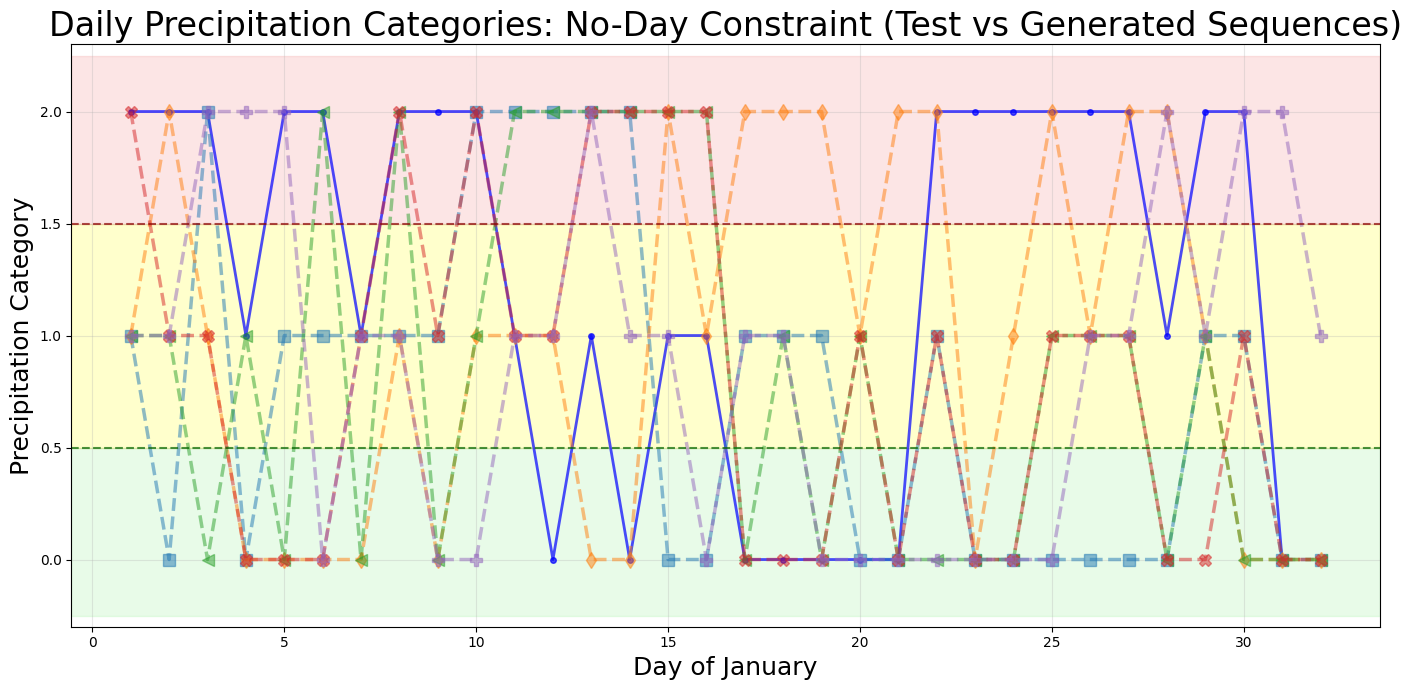


Precipitation Category Distribution:
Test sequence: {'Low': 8, 'Medium': 7, 'High': 16}
Generated #1: {'Low': 14, 'Medium': 12, 'High': 6}
Generated #2: {'Low': 11, 'Medium': 11, 'High': 10}
Generated #3: {'Low': 14, 'Medium': 10, 'High': 8}
Generated #4: {'Low': 13, 'Medium': 12, 'High': 7}
Generated #5: {'Low': 11, 'Medium': 14, 'High': 7}


In [50]:
sequence_line_plot_categorical(random_sequences, 'precip')

In [51]:
def sequence_line_plot_cat(random_sequences, weather_var):
    plt.figure(figsize=(14, 7))

    # Collect all values from all sequences to calculate thresholds
    all_values = []
    
    # Add test sequence values
    all_values.extend(daily_mean_test_df[weather_var].tolist())
    
    # For each generated sequence, collect values
    generated_sequences_data = []
    for idx, gen in enumerate(random_sequences):
        temperature_gen1, precipitation_gen1 = zip(*[str(state).split('-') for state in gen])
        prec_val_gen1 = []
        temp_val_gen1 = []

        for i in temperature_gen1: 
            if i == 'Low': 
                temp_val_gen1.append(float(random.choice(temp_low1)))
            elif i == 'Medium': 
                temp_val_gen1.append(float(random.choice(temp_med1)))
            elif i == 'High': 
                temp_val_gen1.append(float(random.choice(temp_high1)))

        for i in precipitation_gen1: 
            if i == 'Low': 
                prec_val_gen1.append(float(random.choice(prec_low1)))
            elif i == 'Medium': 
                prec_val_gen1.append(float(random.choice(prec_med1)))
            elif i == 'High': 
                prec_val_gen1.append(float(random.choice(prec_high1)))

        df_gen = pd.DataFrame({
            'temp': temp_val_gen1,
            'precip': prec_val_gen1
        })
        df_gen.index = df_gen.index + 1  # match day index
        
        # Store the generated data
        generated_sequences_data.append(df_gen)
        
        # Add values to all_values for threshold calculation
        all_values.extend(df_gen[weather_var].tolist())

    # Calculate thresholds based on all values (test + generated)
    all_values = np.array(all_values)
    low_threshold = np.percentile(all_values, 33.33)
    high_threshold = np.percentile(all_values, 66.67)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    
    # Add colored background zones - only show the actual data range
    y_margin = (max_val - min_val) * 0.05  # 5% margin for better visualization
    plot_min = min_val - y_margin
    plot_max = max_val + y_margin
    
    plt.axhspan(plot_min, low_threshold, alpha=0.2, color='lightgreen', label='Low')
    plt.axhspan(low_threshold, high_threshold, alpha=0.2, color='yellow', label='Medium')
    plt.axhspan(high_threshold, plot_max, alpha=0.2, color='lightcoral', label='High')

    # Plot the actual (test) sequence
    days = daily_mean_test_df['day']
    plt.plot(days, daily_mean_test_df[weather_var], marker='o', 
             label=f'Test {weather_var.capitalize()}', color='blue', linewidth=2, markersize=2, alpha=0.7)
    
    markers = ['s', 'd', '<', 'X', 'P']
    # Plot each generated sequence
    for idx, df_gen in enumerate(generated_sequences_data):
        marker = markers[idx % len(markers)]  # Cycle through markers if more sequences than markers
        plt.plot(df_gen.index, df_gen[weather_var], marker=marker, 
                label=f'Generated #{idx+1}', linestyle='--', alpha=0.5, linewidth=2.5, markersize=8)

    # Dynamic label and title based on variable
    y_label = 'Temperature (°C)' if weather_var == 'temp' else 'Precipitation (mm)'
    title_var = 'Temperature' if weather_var == 'temp' else 'Precipitation'

    plt.xlabel('Day of January', size=18)
    plt.ylabel(y_label, size=18)
    plt.title(f'Average Daily {title_var}: No-Day Constraint (Test vs Generated Sequences)', size=26)
    plt.grid(True, alpha=0.3)
    
    # Create legend with categories and sequences
    plt.legend(loc='upper right', fontsize=12)
    
    # Add threshold lines for clarity
    plt.axhline(y=low_threshold, color='darkgreen', linestyle='--', alpha=0.7, linewidth=1)
    plt.axhline(y=high_threshold, color='darkred', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print threshold information
    print(f"\n{title_var} Categorization Thresholds:")
    print(f"Low: ≤{low_threshold:.2f} (bottom 33.33% of data)")
    print(f"Medium: {low_threshold:.2f} to {high_threshold:.2f} (middle 33.33% of data)")
    print(f"High: ≥{high_threshold:.2f} (top 33.33% of data)")
    if weather_var == 'temp':
        print(f"Plot range: {plot_min:.2f} (min from temp_low1) to {plot_max:.2f} (max from temp_high1)")
    else:
        print(f"Plot range: {plot_min:.2f} (min from prec_low1) to {plot_max:.2f} (max from prec_high1)")

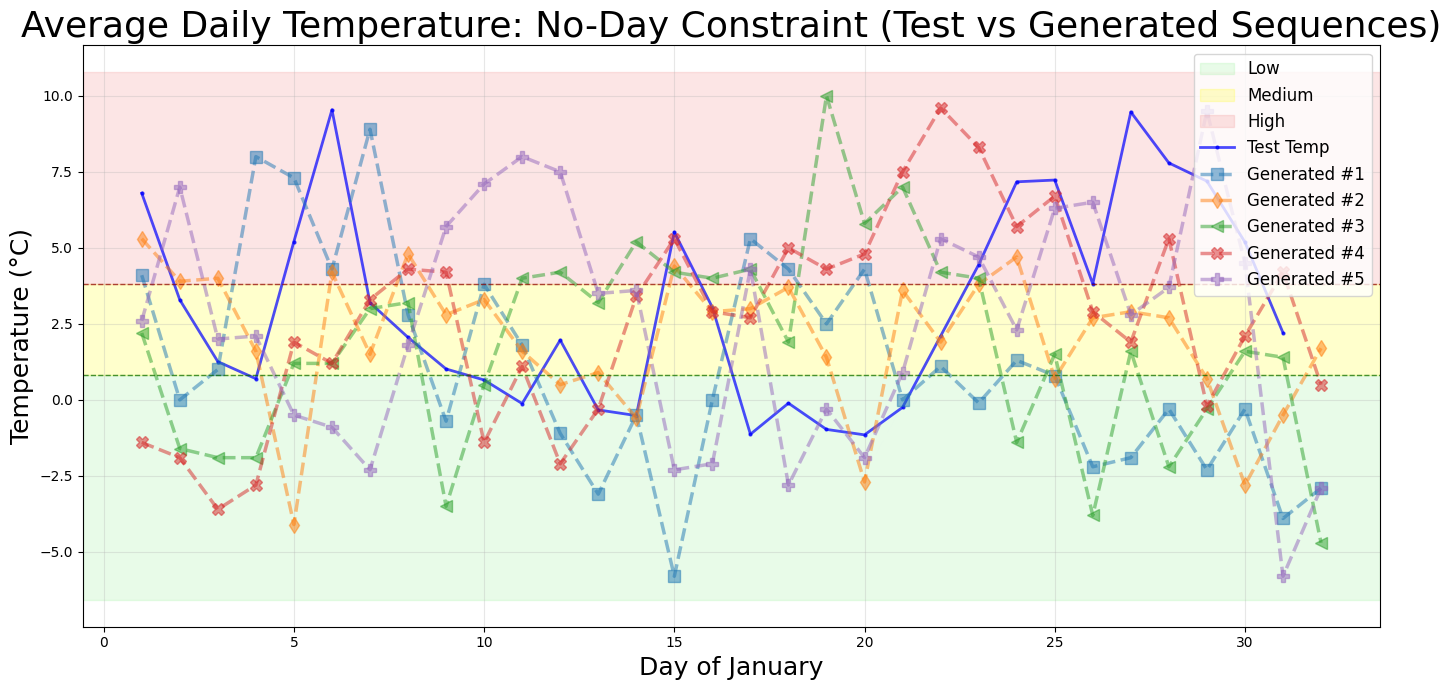


Temperature Categorization Thresholds:
Low: ≤0.83 (bottom 33.33% of data)
Medium: 0.83 to 3.80 (middle 33.33% of data)
High: ≥3.80 (top 33.33% of data)
Plot range: -6.59 (min from temp_low1) to 10.79 (max from temp_high1)


In [52]:
sequence_line_plot_cat(random_sequences, 'temp')

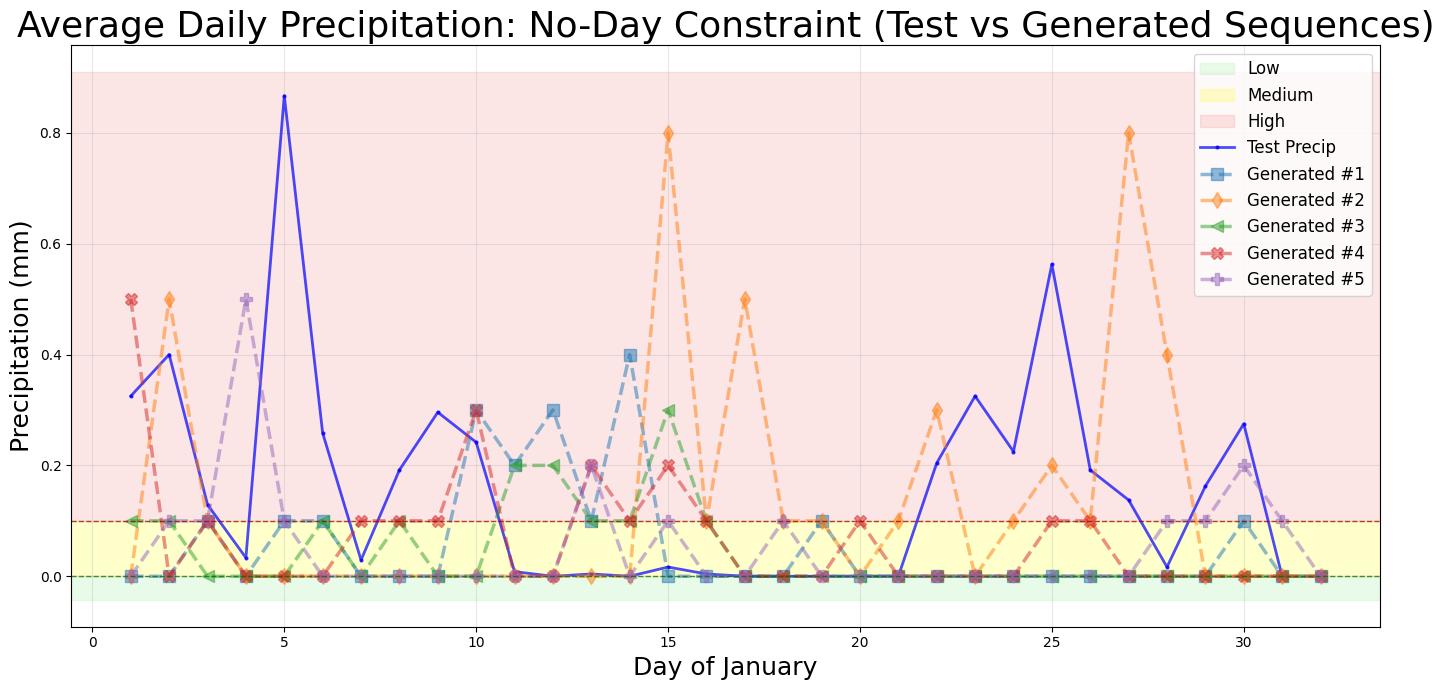


Precipitation Categorization Thresholds:
Low: ≤0.00 (bottom 33.33% of data)
Medium: 0.00 to 0.10 (middle 33.33% of data)
High: ≥0.10 (top 33.33% of data)
Plot range: -0.04 (min from prec_low1) to 0.91 (max from prec_high1)


In [53]:
sequence_line_plot_cat(random_sequences, 'precip')